In [3]:
'''
Created on 2024-09-24 by Shih-Che Lin
Scripts were run on Python 3.9.12 upon writing
'''
import numpy as np
import pandas as pd 
from matplotlib import pyplot as plt
import os
import csv
from matplotlib import gridspec
from scipy import linalg, fft as sp_fft
from scipy.interpolate import interp1d
import itertools
import scipy
import pickle
from scipy.signal import correlate
import seaborn as sns
from scipy import stats

np.seterr(divide='ignore',invalid='ignore')

%matplotlib inline
from matplotlib import rc,rcParams
from pylab import *
# Set the ticks and label of figure

# plt.rcParams.update(matplotlib.rcParamsDefault)
params = {        
         'axes.spines.right': False,
         'axes.spines.top': False,
         'axes.spines.left': True,
         'axes.spines.bottom': True,
         "axes.linewidth" : 1.5,
         #Set axis tick line width
        "xtick.major.width" : 1.5,
        "ytick.major.width" : 1.5,}
        #  "font.weight" : "bold",
        #  "axes.labelweight" : "bold",}
        #  "axes.titleweight" : "bold"}
plt.style.use('default')
plt.rcParams.update(params)

In [25]:
def generate_metadata(file_dir, file_name, bin_num = 4):
    '''
    Summarize preprocessed extraction file into readable dictionary
    '''
    data = pd.read_csv(os.path.join(file_dir,file_name),header = None, low_memory=False).values
    row_names = np.array(data[:,0], dtype = 'str')
    bin_start_index = np.where(np.array(['Bin SNR' in tt for tt in row_names]))[0][0]+1
    trace_start_index = np.where(np.array([tt == 'Time (s)' for tt in row_names]))[0][0]+1

    metadata = {
        'Cell ID': data[1,1:],
        # 'Mouse ID': np.array([f.removesuffix('.csv').split('_')[1] for f in data[0,1:]]),
        # 'Date': np.array([f.split('_')[0][-8:] for f in data[0,1:]]),    
        'Stimulus':data[2,1:],
        'File name': data[0,1:],
        'Trace time': np.array(data[trace_start_index:, 0] ,dtype = 'float'), 
        'Calcium trace': np.array(data[trace_start_index:, 1:],dtype = 'float'),
        'Standardized bin': np.array(data[bin_start_index:bin_start_index+bin_num,1:],dtype = 'float'),
        'AUC': np.array(data[6,1:],dtype = 'float'),
        'Baseline AUC': np.array(data[5,1:],dtype = 'float'),
        'Baseline mean': np.array(data[3,1:],dtype = 'float'),
        'Baseline std': np.array(data[4,1:],dtype = 'float'),
        'Bin response': np.array(data[10,1:], dtype = 'str')
    }
    return metadata

def read_file(File_name, delimiter):
    data = []
    with open(File_name, newline = '') as f:                                                                                          
        f_reader = csv.reader(f, delimiter=delimiter)
        for l in f_reader:
            data.append(l)
    return np.array(data)

In [ ]:
# Upsampling & downsampling
def resample(x, num, t=None, axis=0, window=None, domain='time'):
    """
    Parameters:
    ---------
    x : array_like
        The data to be resampled.
    num : int
        The number of samples in the resampled signal.
    t : array_like, optional
        If `t` is given, it is assumed to be the equally spaced sample
        positions associated with the signal data in `x`.
    axis : int, optional
        The axis of `x` that is resampled.  Default is 0.
    window : array_like, callable, string, float, or tuple, optional
        Specifies the window applied to the signal in the Fourier
        domain.  See below for details.
    domain : string, optional
        A string indicating the domain of the input `x`:
        ``time`` Consider the input `x` as time-domain (Default),
        ``freq`` Consider the input `x` as frequency-domain.

    Return:
    -------
    resampled_x or (resampled_x, resampled_t)
        Either the resampled array, or, if `t` was given, a tuple
        containing the resampled array and the corresponding resampled
        positions.
    """
    if domain not in ('time', 'freq'):
        raise ValueError("Acceptable domain flags are 'time' or"
                         " 'freq', not domain={}".format(domain))
    x = np.asarray(x)
    Nx = x.shape[axis]

    # Check if we can use faster real FFT
    real_input = np.isrealobj(x)

    if domain == 'time':
        # Forward transform
        if real_input:
            X = sp_fft.rfft(x, axis=axis)
        else:  # Full complex FFT
            X = sp_fft.fft(x, axis=axis)
    else:  # domain == 'freq'
        X = x

    # Apply window to spectrum
    if window is not None:
        if callable(window):
            W = window(sp_fft.fftfreq(Nx))
        elif isinstance(window, np.ndarray):
            if window.shape != (Nx,):
                raise ValueError('window must have the same length as data')
            W = window
        else:
            W = sp_fft.ifftshift(signal.get_window(window, Nx))

        newshape_W = [1] * x.ndim
        newshape_W[axis] = X.shape[axis]
        if real_input:
            # Fold the window back on itself to mimic complex behavior
            W_real = W.copy()
            W_real[1:] += W_real[-1:0:-1]
            W_real[1:] *= 0.5
            X *= W_real[:newshape_W[axis]].reshape(newshape_W)
        else:
            X *= W.reshape(newshape_W)

    # Copy each half of the original spectrum to the output spectrum, either
    # truncating high frequences (downsampling) or zero-padding them
    # (upsampling)

    # Placeholder array for output spectrum
    newshape = list(x.shape)
    if real_input:
        newshape[axis] = num // 2 + 1
    else:
        newshape[axis] = num
    Y = np.zeros(newshape, X.dtype)

    # Copy positive frequency components (and Nyquist, if present)
    N = min(num, Nx)
    nyq = N // 2 + 1  # Slice index that includes Nyquist if present
    sl = [slice(None)] * x.ndim
    sl[axis] = slice(0, nyq)
    Y[tuple(sl)] = X[tuple(sl)]
    if not real_input:
        # Copy negative frequency components
        if N > 2:  # (slice expression doesn't collapse to empty array)
            sl[axis] = slice(nyq - N, None)
            Y[tuple(sl)] = X[tuple(sl)]

    # Split/join Nyquist component(s) if present
    # So far we have set Y[+N/2]=X[+N/2]
    if N % 2 == 0:
        if num < Nx:  # downsampling
            if real_input:
                sl[axis] = slice(N//2, N//2 + 1)
                Y[tuple(sl)] *= 2.
            else:
                # select the component of Y at frequency +N/2,
                # add the component of X at -N/2
                sl[axis] = slice(-N//2, -N//2 + 1)
                Y[tuple(sl)] += X[tuple(sl)]
        elif Nx < num:  # upsampling
            # select the component at frequency +N/2 and halve it
            sl[axis] = slice(N//2, N//2 + 1)
            Y[tuple(sl)] *= 0.5
            if not real_input:
                temp = Y[tuple(sl)]
                # set the component at -N/2 equal to the component at +N/2
                sl[axis] = slice(num-N//2, num-N//2 + 1)
                Y[tuple(sl)] = temp

    # Inverse transform
    if real_input:
        y = sp_fft.irfft(Y, num, axis=axis)
    else:
        y = sp_fft.ifft(Y, axis=axis, overwrite_x=True)

    y *= (float(num) / float(Nx))

    if t is None:
        return y
    else:
        new_t = np.arange(0, num) * (t[1] - t[0]) * Nx / float(num) + t[0]
        return y, new_t

In [51]:
file_dir = r"/Users/shihchelin/Desktop/WH Behavioral data analysis/Behavioral neural data"
save_dir = r"/Users/shihchelin/Desktop/WH Behavioral data analysis"
os.chdir(file_dir)
#Create dictionary with neural data & associated information included
neural_data = generate_metadata(file_dir, "Z-score signal extraction & stats.csv", bin_num = 36)
#List of behavioral data files
behavior_d_list = np.array([_ for _ in os.listdir(file_dir) if _.endswith(".csv") and "behaviorlabel" in _])

In [76]:
behavior_d_list

['2024-07-30_14990-1 FOR 1MIN_behaviorlabel.csv',
 '2024-07-30_14990-1 BASAL_behaviorlabel.csv',
 '2024-07-30_14990-1 FOR 2h_behaviorlabel.csv',
 '2024-07-30_14990-1 FOR 30MIN_behaviorlabel.csv']

In [60]:
beh_col = {
    'grooming':'gray',
    'immobility':'red',
    'licking':'green',
    'walking':'blue',
    'rearing':'orange',
}

In [196]:
behavior_meta = {}
stages = ['BASAL','1MIN','30MIN','2h']
behaviors = ['grooming','immobility','licking','walking','rearing']
for st in stages:
    match_file_indx = np.where([st in n for n in behavior_d_list])[0][0]

    beh_raw = pd.read_csv(behavior_d_list[match_file_indx], header = 0)
    behavior_meta[st] = {'time': beh_raw['time'].values}
    for beh in behaviors:
        binary_vec = beh_raw[beh].values
        behavior_meta[st][beh] = {'Binary vector': binary_vec}

        dev = binary_vec[1:] - binary_vec[:-1]
        #Find the start and end of each behavior
        start = np.where(dev == 1)[0]+1
        end = np.where(dev == -1)[0]+1
        if binary_vec[0] == 1: #Fisrt behavior starts from 0
            start = np.insert(start,0,0)
        if binary_vec[-1] == 1: #Last behavior ends at the end of the trace
            end = np.append(end, len(binary_vec)-1)

        duration = end - start

        behavior_meta[st][beh]['Start'] = start
        behavior_meta[st][beh]['End'] = end
        behavior_meta[st][beh]['Duration'] = duration

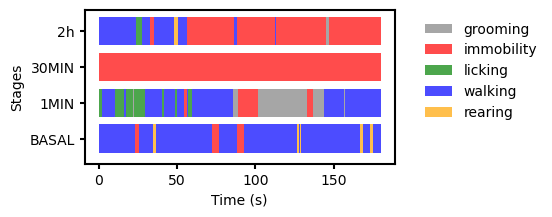

In [154]:
metadata = behavior_meta

fig, ax = plt.subplots(1,1,figsize=(4,2))
for k ,tr in enumerate(stages):

    time = metadata[tr]['time']
    for i , be in enumerate(behaviors):
        data = metadata[tr][be]
        behavior_start , behavior_duration = data['Start'],data['Duration']
       
        [ax.fill_between([time[behavior_start[j]], time[behavior_start[j]]+time[behavior_duration[j]]],k+.1,k+.9, facecolor = beh_col[be], alpha=.7) for j in range(len(behavior_start))];
for i, be in enumerate(behaviors):
    ax.fill_between([0],0,1, facecolor = beh_col[be], alpha=.7, label = be) 
ax.set_yticks(np.arange(len(stages))+.5, stages)
ax.set(xlabel = 'Time (s)', ylabel = 'Stages')#, ylim = (0, len(stages)), xlim = (0, time[-1]))
ax.spines['right'].set_visible(True)
ax.spines['top'].set_visible(True)
ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right', frameon = False) ;

In [197]:
#Resample so that the length of neural data matches with behavioral data 
resamp_t = np.linspace(0, beh_raw['time'].max(), beh_raw['time'].size)

resamp_ca = np.array([resample(neural_data['Calcium trace'][:,i], resamp_t.size) for i in range(neural_data['Calcium trace'].shape[1])]).T

In [198]:
mouse = np.array([fn.split(' ')[1] for fn in neural_data['File name']])
rec_stage = neural_data['Stimulus']

In [199]:
stage_match = {
    'BASAL':'basal',
    '1MIN':'formalin1min',
    '30MIN':'formalin 30min',
    '2h':'formalin 2h'   
}

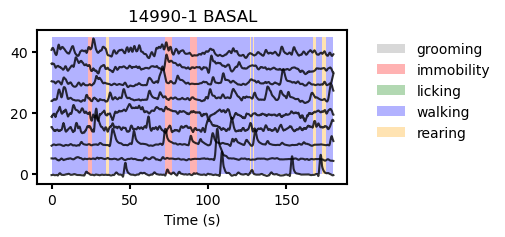

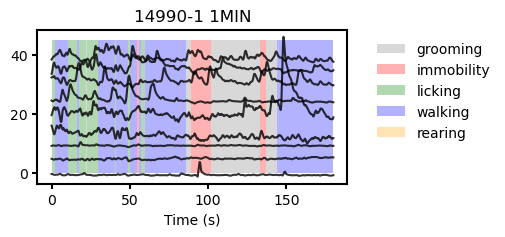

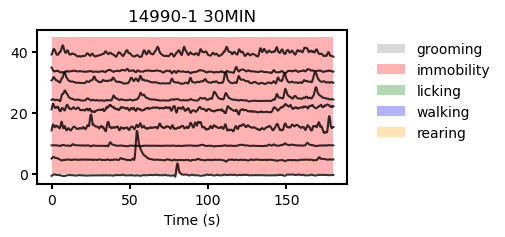

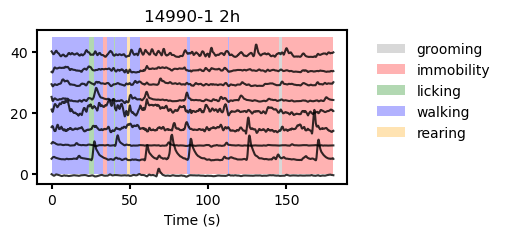

In [200]:
mouse_list = ['14990-1']

metadata = behavior_meta
for m in mouse_list:
    for st in stages:
        fig, ax = plt.subplots(1,1,figsize=(4,2))

        c_indx = np.where(np.logical_and(mouse == m , rec_stage == stage_match[st]))[0]
        ca_trace = resamp_ca[:,c_indx]
        ca_time = resamp_t.copy()

        [ax.plot(ca_time, ca_trace[:,j]+5*j, color = 'black', alpha = .8) for j in range(ca_trace.shape[1])]

        beh_time = metadata[tr]['time']
        for i , be in enumerate(behaviors):
            data = metadata[st][be]
            behavior_start , behavior_duration = data['Start'],data['Duration']
        
            [ax.fill_between([beh_time[behavior_start[j]], beh_time[behavior_start[j]]+time[behavior_duration[j]]],0,5*ca_trace.shape[1],
                              facecolor = beh_col[be], alpha=.3) for j in range(len(behavior_start))];
        for i, be in enumerate(behaviors):
            ax.fill_between([0],0,1, facecolor = beh_col[be], alpha=.3, label = be) 
        # ax.set_yticks(np.arange(len(stages))+.5, stages)
        ax.set(xlabel = 'Time (s)', ylabel = '', title = m+' '+st)
        ax.spines['right'].set_visible(True)
        ax.spines['top'].set_visible(True)
        ax.legend(bbox_to_anchor=(1.5, 1), loc='upper right', frameon = False) ;

In [202]:
pre, post = 5,5
com_t = resamp_t[:np.where(resamp_t <= pre+post)[0].max()] - pre
t0_indx = np.where(com_t >= 0)[0].min()

In [252]:
joint_data = {}
mouse_list = ['14990-1']
stages = ['BASAL','1MIN','30MIN','2h']
behaviors = ['grooming','immobility','licking','walking','rearing']
#One data per stage
for st in stages:
    joint_data[st] = {}
    #Find index where mouse id in mouse_list and stage matches
    includ_indx = np.where(np.logical_and(rec_stage == stage_match[st], np.isin(mouse, mouse_list)))[0]
    raw_traces = resamp_ca[:,includ_indx]
    mouse_id = mouse[includ_indx]
    #Find the corresponding behavioral data
    beh_data = behavior_meta[st]
    beh_time = beh_data['time']
    for beh in behaviors:
        beh_start = beh_data[beh]['Start']
        beh_end = beh_data[beh]['End']
        beh_duration = beh_data[beh]['Duration']
        #Exclude behavioral events with preceed / post extraction time exceeding the trace length
        valid_indx = np.where(np.logical_and(beh_time[beh_start] > pre, beh_time[beh_end] < beh_time.max()-post))[0]
        #Find the calcium trace that corresponds to the behavior
        all_z_traces = np.zeros((com_t.size,raw_traces.shape[1],valid_indx.size)) #Time x Neurons x Behavior bouts
        if len(valid_indx) == 0:
            print('No valid data for '+st+' '+beh)
            continue

        for ii, i in enumerate(valid_indx):
            t0 = beh_time[beh_start[i]]
            # print(t0)
            start, end = np.where(beh_time >= t0 - pre)[0].min(), np.where(beh_time <= t0 + post)[0].max()
            z_trace = raw_traces[start:end,:]
            #Adjust signal length
            if z_trace.shape[0] < com_t.size:
                print(z_trace.shape[0] - com_t.size)
                z_trace = np.pad(z_trace, ((0,com_t.size-z_trace.shape[0]),(0,0)), 'reflect')
            elif z_trace.shape[0] > com_t.size:
                z_trace = z_trace[:com_t.size,:]
            #Normalization 
            z_trace = (z_trace - z_trace[:t0_indx,:].mean(axis = 0))/z_trace[:t0_indx,:].std(axis = 0)
            #Update pool trace data
            all_z_traces[:,:,ii] = z_trace
        mean_z_trace = all_z_traces.mean(axis = 2)
        std_z_trace = all_z_traces.std(axis = 2)
        # all_z_traces /= len(valid_indx)
        joint_data[st][beh] = {'Mean': mean_z_trace, 'Std': std_z_trace, 'Raw': all_z_traces}

No valid data for BASAL grooming
No valid data for BASAL licking
-1
-1
-1
-1
No valid data for 1MIN rearing
No valid data for 30MIN grooming
No valid data for 30MIN immobility
No valid data for 30MIN licking
No valid data for 30MIN walking
No valid data for 30MIN rearing


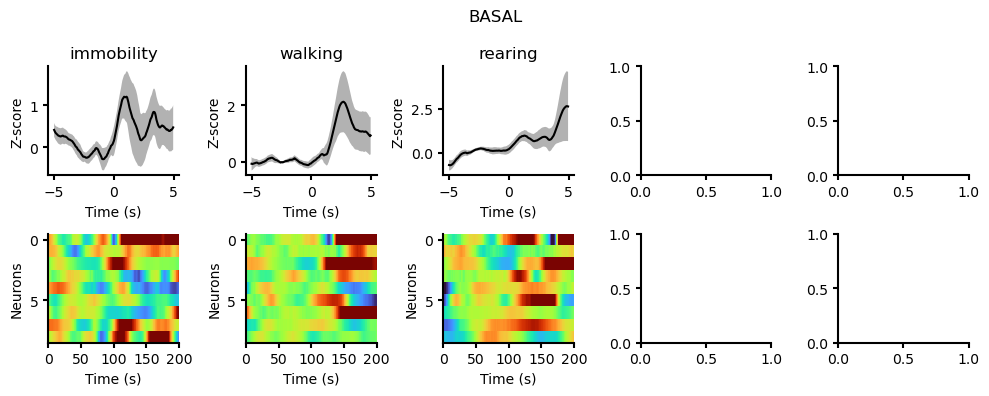

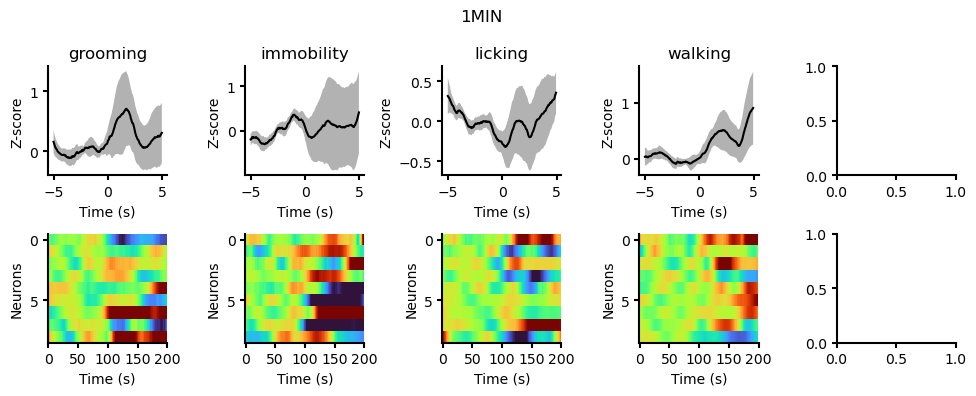

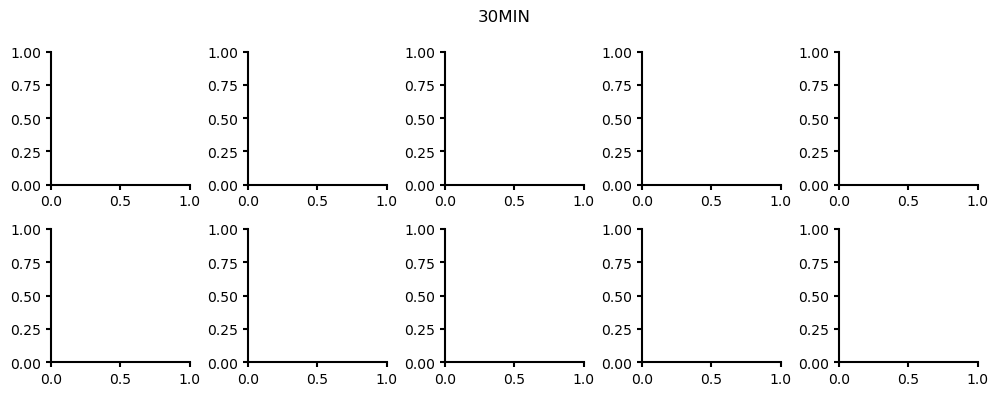

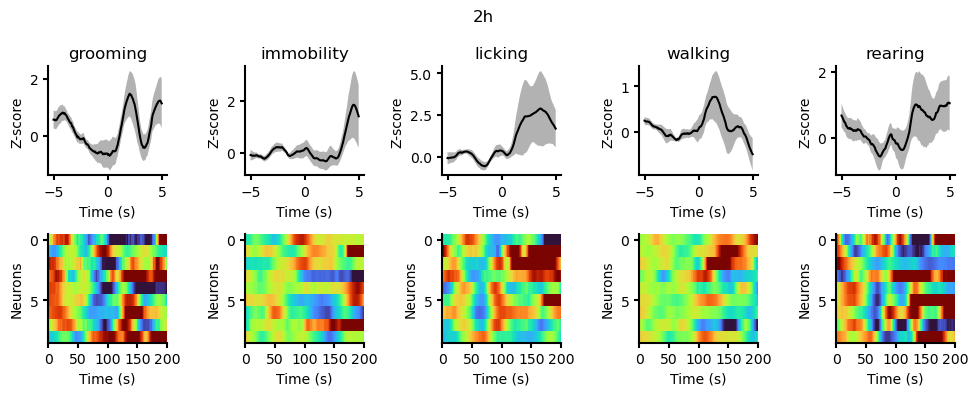

In [275]:
for stages in joint_data.keys():
    fig, ax = plt.subplots(2,len(behaviors),figsize=(10,4))
    for i, beh in enumerate(joint_data[stages].keys()):
        mean_trace = joint_data[stages][beh]['Mean']
        std_trace = mean_trace.std(axis = 1)/np.sqrt(mean_trace.shape[1])
        ax[0,i].plot(com_t, mean_trace.mean(axis = 1), color = 'black')
        ax[0,i].fill_between(com_t, mean_trace.mean(axis =1)-std_trace, mean_trace.mean(axis = 1)+std_trace, facecolor = 'black', alpha = .3)
        ax[0,i].set(xlabel = 'Time (s)', ylabel = 'Z-score', title = beh)

        ax[1,i].imshow(mean_trace.T, aspect = 'auto', cmap = 'turbo', interpolation='none', vmax = 2, vmin = -2)    
        ax[1,i].set(xlabel = 'Time (s)', ylabel = 'Neurons')
        ax[1,i].set_xticks(np.arange(0,mean_trace.shape[0]+1,50))
    fig.suptitle(stages)
    fig.tight_layout()